In [1]:
from lmfit import minimize, Parameters # Parameter, report_fit

In [2]:
import numpy as np
import xsimlab as xs
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['figure.figsize'] = [15, 10]

### create minimal ODE system example: 
## Phytoplankton growing in chemostat (constant flowthrough)

In [4]:
halfsat = 0.5
flow = 0.3
N0 = 2
#init = [1,0.01]

def chemostat(t,x):
    
    N,P = x
    
    nutuptake = N / (halfsat + N) 
    
    dPdt = nutuptake * P - flow * P
    
    dNdt = flow * N0 - nutuptake * P  - flow * N
    
    return [dNdt, dPdt]

## Solve this model with xsimlab (time-explicit)

In [5]:
@xs.process
class MODEL:
    x = xs.variable(dims='x', intent='inout')
    out = xs.variable(dims=('x'),intent='out')
    outflux = xs.variable(dims=('x'),intent='out')
    init = xs.variable(dims=('x'),intent='in')
    
    def initialize(self):
        self.out = self.init
        self.time = 0
    
    @xs.runtime(args='step_delta')
    def run_step(self,dt):
        # need to convert fluxes to correct time step with dt
        self.outflux = chemostat(self.time, self.out) * dt
        # keep track of timestep for forcing (+ other time dep. processes)
        self.time += dt
    
    def finalize_step(self):
        self.out = np.array(self.out) + np.array(self.outflux)

In [6]:
MOD = xs.Model({'m':MODEL})

indat = xs.create_setup(
  model=MOD,
     clocks={
         'time': np.linspace(0,40,1000)
     },
     input_vars={
         'm__x':('x',['N','P']),
         'm__init':('x',[1,0.1])
     },
     output_vars={
        'm__x': None,
        'm__out':'time',
        'm__outflux':'time'
     }  
)

In [7]:
out1 = indat.xsimlab.run(model=MOD)

In [8]:
out = out1.set_index(x='m__x')
out

<xarray.Dataset>
Dimensions:     (time: 1000, x: 2)
Coordinates:
  * time        (time) float64 0.0 0.04004 0.08008 0.1201 ... 39.92 39.96 40.0
  * x           (x) object 'N' 'P'
Data variables:
    m__init     (x) float64 1.0 0.1
    m__out      (time, x) float64 1.0 0.1 1.009 0.1015 ... 1.786 0.2143 1.786
    m__outflux  (time, x) float64 0.009343 0.001468 ... -1.294e-08 7.546e-08

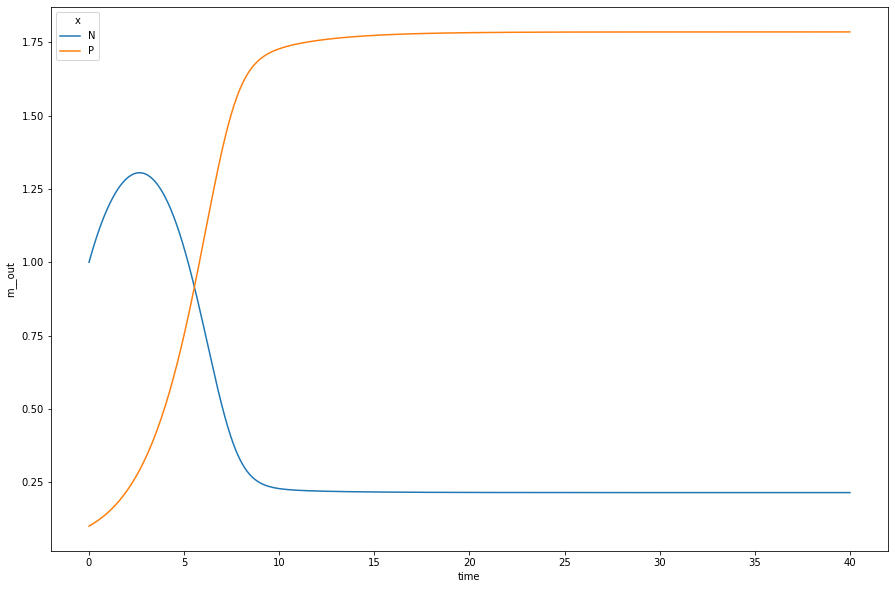

In [9]:
out.m__out.plot.line(x='time')

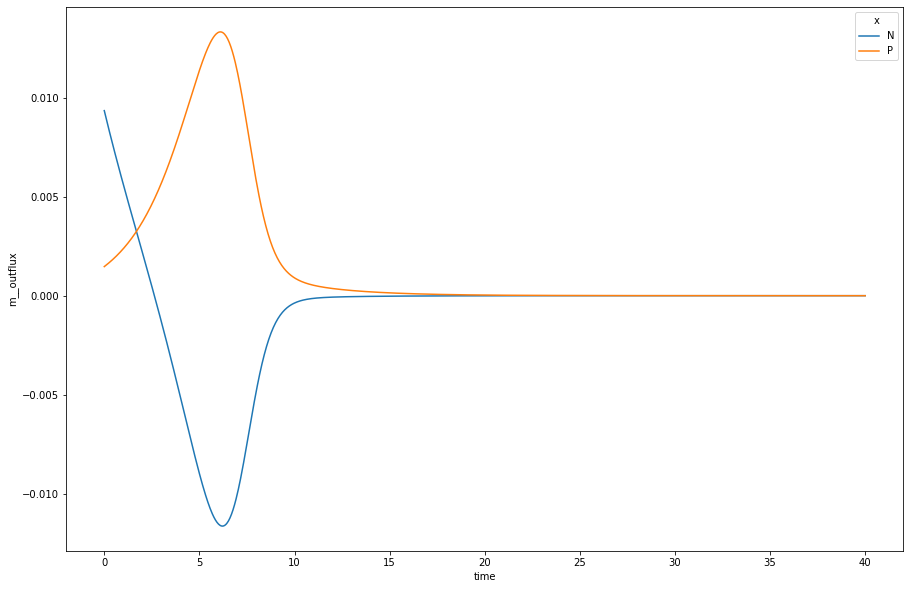

In [10]:
out.m__outflux.plot.line(x='time')

# Now let's attempt a fully flexible xsimlab implementation

Note: This didn't really work out as I had intended, that is why i moved on to develop ASTroCAT in a different way.
The way fluxes are assembled to be solved is inspired from your model sketch, but it seems that I haven't fully realised the flexibility here in this example. There is the possibility to add multiple instances of each component (either N or P), but it is not possible to specify individual parameters. 

In [61]:
@xs.process
class ChemostatParameters:
    N_init = xs.variable(intent='in')
    P_init = xs.variable(intent='in')  

    N_inputconc = xs.variable(intent='in', groups='input', static=True)
    flowrate = xs.variable(intent='in', groups='parameter', static=True)
    halfsat = xs.variable(intent='in', groups='parameter', static=True)
    
    #P1_halfsat = xs.variable(intent='in', groups='parameter', static=True)
    #P2_halfsat = xs.variable(intent='in', groups='parameter', static=True)
    #P3_halfsat = xs.variable(intent='in', groups='parameter', static=True)

In [62]:
@xs.process
class Component:
    num = xs.variable(intent='out')
    label = xs.variable(intent='out', groups='label')
    flux = xs.variable(intent='out', groups='flux', description='ODE expression of component')
    init = xs.variable(intent='out', groups='init')
    
    def _flux(self, state, time):
        """
        Parameters
        ----------
        state : dict
            Keys are ecosystem component labels and values are
            concentrations at current time.
        time : float
            Current time.
        """
        # must be implemented in subclasses
        raise NotImplementedError
        
    def initialize(self):
        # this is a hack, ideally I would like to have some variable keeping track of all initialized components, but within each component in order
        global component_num
        
        self.num = component_num
        self.label = self.component_label + str(self.num)
        
        component_num += 1
        
        self.init = self.initVal
        self.flux = self._flux

In [63]:
@xs.process
class Nutrient(Component):
    component_label = xs.variable(default='N')
    initVal = xs.foreign(ChemostatParameters, 'N_init')
    
    N_inputconc = xs.foreign(ChemostatParameters, 'N_inputconc')
    flowrate = xs.foreign(ChemostatParameters, 'flowrate')
    halfsat = xs.foreign(ChemostatParameters, 'halfsat')
    
    def _flux(self, *args):
        state, time, labels = args
        P_labels = [plabel for plabel in labels if plabel[0] == 'P']
        Ps = sum([state[plabel] for plabel in P_labels])
        N = state[self.label]
        
        return(
        self.N_inputconc * self.flowrate - N / (N + self.halfsat) * Ps - self.flowrate * N
        )

@xs.process
class Phytoplankton(Component):
    component_label = xs.variable(default='P')
    initVal = xs.foreign(ChemostatParameters, 'P_init')
    
    N_inputconc = xs.foreign(ChemostatParameters, 'N_inputconc')
    flowrate = xs.foreign(ChemostatParameters, 'flowrate')
    halfsat = xs.foreign(ChemostatParameters, 'halfsat')
    
    def _flux(self, *args):
        state, time, labels = args
        N_labels = [nlabel for nlabel in labels if nlabel[0] == 'N']
        Ns = sum([state[nlabel] for nlabel in N_labels])
        P = state[self.label]
        
        return( 
        Ns / (Ns + self.halfsat) * P - self.flowrate * P
        )


In [64]:
@xs.process
class ModelSolver:
    labels = xs.group('label')
    init = xs.group('init')
    
    fluxes = xs.group('flux')
 
    component = xs.variable(dims=('component'), intent='out')
    
    state = xs.variable(dims=('component'),intent='out')
    stateout = xs.variable(dims=('component'),intent='out')
    outflux = xs.variable(dims=('component'),intent='out')
    
    def initialize(self):
        self.time = 0
        self.state = {label: val for label, val in zip(self.labels, self.init)}
        self.stateout = [self.state[label] for label in self.labels]
        self.funcs = {label: flux for label, flux in zip(self.labels, self.fluxes)}
        
        self.component = [i for i in self.labels]


    @xs.runtime(args='step_delta')
    def run_step(self,dt):
        # need to convert fluxes to correct time step by multiplying by dt
        self.outflux = {label : self.funcs[label](self.state, self.time, self.labels) * dt for label in self.labels}
        # keep track of timestep for forcing (+ other time dep. processes)
        self.time += dt
    
    def finalize_step(self):
        self.state = {label : self.state[label] + self.outflux[label] for label in self.labels}
        self.stateout = [self.state[label] for label in self.labels]
        #print(self.state)

In [65]:
# This should be the ideal setup way:
flextestModelSetup = xs.Model({'MS':ChemostatParameters,
                               'N':Nutrient, 
                               'P1':Phytoplankton, 'P2':Phytoplankton, 'P3':Phytoplankton, 
                               'ModelSolver':ModelSolver})

In [66]:
flextestModelSetup.all_vars_dict

{'MS': ['N_init', 'P_init', 'N_inputconc', 'flowrate', 'halfsat'],
 'N': ['num',
  'label',
  'flux',
  'init',
  'component_label',
  'initVal',
  'N_inputconc',
  'flowrate',
  'halfsat'],
 'P1': ['num',
  'label',
  'flux',
  'init',
  'component_label',
  'initVal',
  'N_inputconc',
  'flowrate',
  'halfsat'],
 'P2': ['num',
  'label',
  'flux',
  'init',
  'component_label',
  'initVal',
  'N_inputconc',
  'flowrate',
  'halfsat'],
 'P3': ['num',
  'label',
  'flux',
  'init',
  'component_label',
  'initVal',
  'N_inputconc',
  'flowrate',
  'halfsat'],
 'ModelSolver': ['labels',
  'init',
  'fluxes',
  'component',
  'state',
  'stateout',
  'outflux']}

In [67]:
# flextestModelSetup.visualize(show_inputs=True)

In [68]:
# this is one way to create an lmfit.Parameter object:
parameters = Parameters()

parameters.add('MS__N_init', value=1,  vary=False)
parameters.add('MS__P_init', value=0.1, vary=False)

parameters.add('MS__N_inputconc', value=2,  vary=False)
parameters.add('MS__flowrate', value=0.2,  vary=False)
parameters.add('MS__halfsat', value=0.5,  vary=False)


# this doesn't work:
#parameters.add('MS__P1_halfsat', value=0.15,  vary=False)
#parameters.add('MS__P2_halfsat', value=0.17,  vary=False)
#parameters.add('MS__P3_halfsat', value=0.145,  vary=False)


In [69]:
def parameterDict2Input_vars(params):
    params = {key : value for key, value in params.valuesdict().items()} 
    
    return params

In [70]:
parameterDict2Input_vars(parameters)

{'MS__N_init': 1,
 'MS__P_init': 0.1,
 'MS__N_inputconc': 2,
 'MS__flowrate': 0.2,
 'MS__halfsat': 0.5}

In [76]:
flextestModelSetup_in = xs.create_setup(
 model=flextestModelSetup,
    clocks={
         'time': np.linspace(0,20,1000)
     },
    
    input_vars = parameterDict2Input_vars(parameters),
    
    output_vars={
        'ModelSolver__component' : None,
        'ModelSolver__stateout'  : 'time',
        'ModelSolver__outflux': 'time'
    }
    
)

In [77]:
component_num = 1
out = flextestModelSetup_in.xsimlab.run(model=flextestModelSetup)

In [78]:
out2 = out.set_index(component='ModelSolver__component')

In [79]:
out2

<xarray.Dataset>
Dimensions:                (component: 4, time: 1000)
Coordinates:
  * time                   (time) float64 0.0 0.02002 0.04004 ... 19.98 20.0
  * component              (component) object 'N1' 'P2' 'P3' 'P4'
Data variables:
    P2__component_label    <U1 'P'
    N__component_label     <U1 'N'
    P1__component_label    <U1 'P'
    P3__component_label    <U1 'P'
    MS__N_init             int64 1
    MS__P_init             float64 0.1
    MS__N_inputconc        int64 2
    MS__flowrate           float64 0.2
    MS__halfsat            float64 0.5
    ModelSolver__stateout  (time, component) float64 1.0 0.1 ... 0.6204 0.6204
    ModelSolver__outflux   (time) object {'N1': 0.0, 'P2': 0.0009342676009342675, 'P3': 0.0009342676009342675, 'P4': 0.0009342676009342675} ... {'N1': -4.753622309054897e-06, 'P2': 1.8627641981626635e-05, 'P3': 1.8627641981626635e-05, 'P4': 1.8627641981626635e-05}

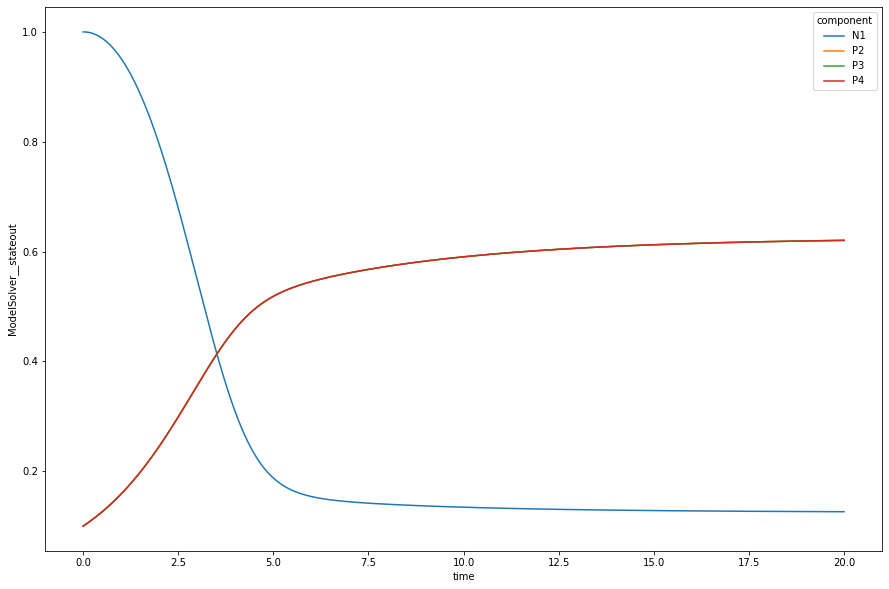

In [80]:
out2.ModelSolver__stateout.plot.line(x='time')

# Now this works in a very limited way

the individual parametrisation does not work

the way lmfit parameters can be passed through to xsimlab i used here seems simple, and allows for the use of the minimizer function (for parameter fitting)

Now what I did for the ASTroCAT_MODEL is instead of creating an instance of each component, I would have components that simply contain arrays for all parameters, according to the number of types created. This property of the model code, to allow for multiple instances of Phytoplankton (for example) is quite central to the utility of the planned package. This will probably make more sense in the ASTroCAT_MODEL notebook.